In [1]:
# Import the Libraries
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D,AveragePooling1D, Flatten, Dense,Dropout, BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorﬂow import random
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
from numpy.random import seed
import tensorflow as tf

#load data 
Temp = pd.read_csv("Temp.csv", header = None)
Property= pd.read_csv("Property.csv")
UTS=Property['UTS']
UTS = UTS.values
UTS = np.array(UTS)

Temp0 = Temp.T
Temp1 = Temp0.values
temp2 = Temp1[:,::10]
Temp1=temp2

#Post-process data and split into training and testing
xscaler = MinMaxScaler(feature_range = (0, 1))
yscaler = MinMaxScaler(feature_range = (0, 1))
Temp1 = xscaler.fit_transform(Temp1)

print(max(UTS), min(UTS))
UTS = UTS.reshape(-1,1)
UTS = yscaler.fit_transform(UTS)
UTS = UTS.reshape(-1,)

Input=Temp1.reshape(97,1000,1)

tf.random.set_seed(116)
Input_shuffle = tf.random.shuffle(Input, seed=1357).numpy()
tf.random.set_seed(116)
UTS_shuffle = tf.random.shuffle(UTS, seed=1357).numpy()

train_x, test_x, train_y, test_y = train_test_split(Input_shuffle, UTS_shuffle, test_size =0.3, shuffle = False)
train_x.shape


Using TensorFlow backend.


830.492268 577.6442557999999


(67, 1000, 1)

In [2]:

#1D CNN model 
n_timesteps= train_x.shape[1]
n_features=train_x.shape[2];
n_outputs= 1

label_ = 'relu'

seed(1)
tf.random.set_seed(2)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation=label_, input_shape=(n_timesteps,n_features)))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation=label_))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation=label_))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, use_bias=True,activation=label_))
model.add(Dense(80, use_bias=True,activation=label_))
model.add(Dense(n_outputs, activation=label_, use_bias = True) )

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 996, 32)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 498, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 494, 64)           10304     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 247, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 243, 64)           20544     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 121, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)             

In [3]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
#fit model
epochs, batch_size = 500, 32
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data = (test_x, test_y), verbose = 0,callbacks=[es])


Epoch 00233: early stopping


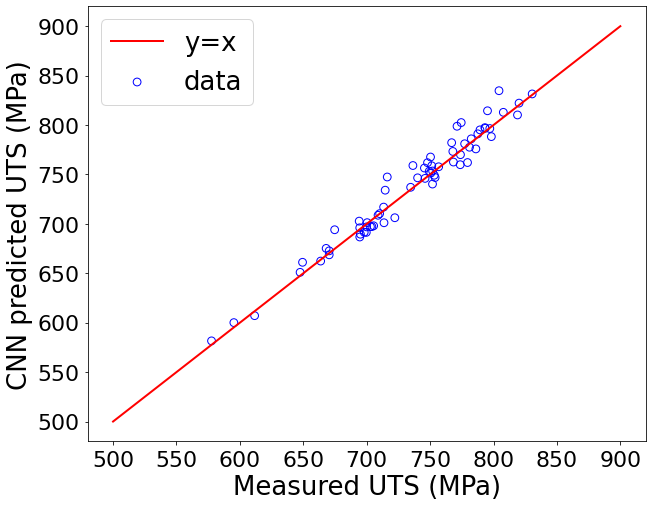

In [7]:
#inverse scale
y_train_predt = model.predict(train_x)
y_train_predt_inverse = yscaler.inverse_transform(y_train_predt)
y_train_mea_inverse = yscaler.inverse_transform(train_y.reshape(-1,1))
y_test_predt = model.predict(test_x)
y_test_predt_inverse = yscaler.inverse_transform(y_test_predt)
y_test_mea_inverse = yscaler.inverse_transform(test_y.reshape(-1,1))

# Plot training results
plt.subplots(figsize = (10,8))
plt.scatter(y_train_mea_inverse, y_train_predt_inverse,facecolor = 'none', edgecolor = 'blue',s = 60, label = 'data')
jjj = np.linspace(500,900,100)
hhh = jjj
plt.plot(jjj, hhh, lw = 2., color = 'r', label='y=x')
plt.xlabel('Measured UTS (MPa)', fontsize = 26)
plt.ylabel('CNN predicted UTS (MPa)', fontsize = 26)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.tick_params(axis='both', which='major', pad=5)
plt.legend(fontsize = 26, loc = 'best')
plt.show()

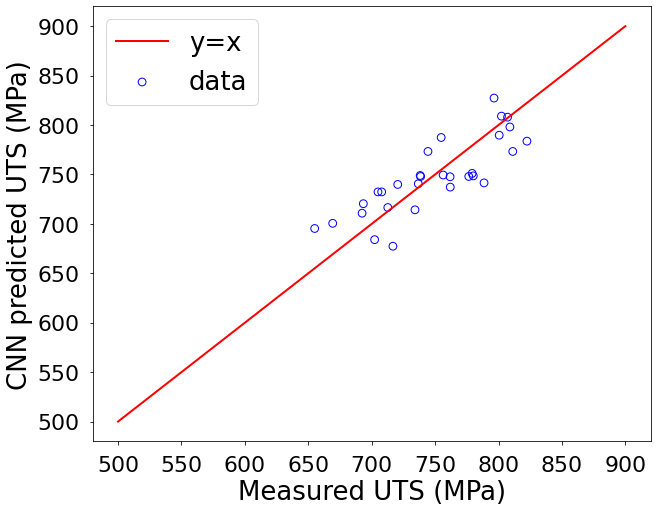

In [8]:
# Plot test results
plt.subplots(figsize = (10,8))
plt.scatter(y_test_mea_inverse, y_test_predt_inverse, facecolor = 'none', edgecolor = 'b', s = 60, label = 'data' )
jjj = np.linspace(500,900,100)
hhh = jjj
plt.plot(jjj, hhh, lw = 2., color = 'r', label='y=x')
plt.xlabel('Measured UTS (MPa)', fontsize = 26)
plt.ylabel('CNN predicted UTS (MPa)', fontsize = 26)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.tick_params(axis='both', which='major', pad=10)
plt.legend(fontsize = 26, loc = 'best')
plt.show()

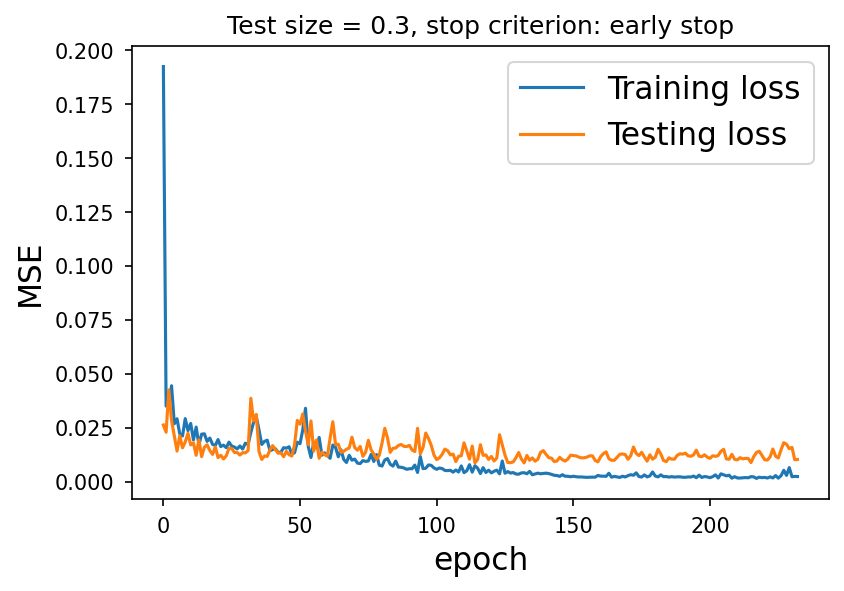

Train: 0.957, Test: 0.671


In [9]:
plt.subplots(dpi = 150)
plt.plot(history.history["loss"], label = 'Training loss')
plt.plot(history.history["val_loss"], label = 'Testing loss')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.tick_params(axis='both', which='major', pad=5)
plt.title('Test size = 0.3, stop criterion: early stop')
plt.legend(fontsize = 15)
plt.show()

from sklearn.metrics import r2_score
r2_error_train=r2_score(train_y, y_train_predt)
r2_error_test=r2_score(test_y, y_test_predt)
r2_error_test2=r2_score(y_test_mea_inverse, y_test_predt_inverse)
print('Train: %.3f, Test: %.3f' % (r2_error_train,r2_error_test))